# Example modeling process

### Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

### Load training data and labels

In [2]:
x_train = get_training_observations()
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [36]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [31]:
y_train['EMPO_3'].value_counts()

Soil (non-saline)          303
Water (saline)             290
Water (non-saline)         245
Subsurface (non-saline)    144
Plant rhizosphere           96
Sediment (non-saline)       73
Animal proximal gut         39
Hypersaline (saline)        15
Sediment (saline)           14
Aerosol (non-saline)         8
Plant surface                6
Surface (saline)             6
Surface (non-saline)         5
Animal corpus                4
Plant corpus                 1
Name: EMPO_3, dtype: int64

In [8]:
y_train['EMPO_3'].nunique()

15

### Data manipulation
Validation splits, dimensionality reduction, etc

In [3]:
# Split into train/validation if not CV
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2) #, random_state=1)
# Dimensionality reduction?
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(X_tr)
new_x_train = svd.transform(X_tr)
new_x_val = svd.transform(X_val)

In [4]:
Y3_tr, Y3_val = Y_tr['EMPO_3'], Y_val['EMPO_3']
# label encoding
lc3_tr = LabelEncoder()
lc3_tr = lc3_tr.fit(Y3_tr)
Y3_tr = lc3_tr.transform(Y3_tr)

lc3_val = LabelEncoder()
lc3_val = lc3_val.fit(Y3_val)
Y3_val = lc3_val.transform(Y3_val)

In [5]:
d_train = xgb.DMatrix(X_tr, label=Y3_tr)
d_val = xgb.DMatrix(X_val, label=Y3_val)

# Baseline

In [6]:
params = {
    # parameters to tune
    'eta':0.01,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0,
    'lambda':1,
    'alpha':0,
    'subsample':1,
    'colsample_bytree':1,
    # other parameters
    'objective':'multi:softmax',
    'num_class':15,
    'eval_metric':'mlogloss'
}
num_boost_round = 999

[0]	Validation-mlogloss:2.70898
[1]	Validation-mlogloss:2.71023
[2]	Validation-mlogloss:2.71167
[3]	Validation-mlogloss:2.71345
[4]	Validation-mlogloss:2.71551


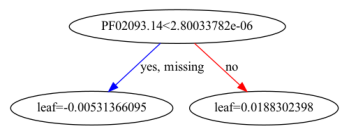

Best Multiclass Log Loss: 2.71 with 1 rounds


In [7]:
model3 = xgb.train(
    params, 
    d_train,
    num_boost_round = num_boost_round,
    evals=[(d_val, "Validation")],
    early_stopping_rounds=5
)
# plot single tree
plot_tree(model3)
plt.show()
print("Best Multiclass Log Loss: {:.2f} with {} rounds".format(
                 model3.best_score,
                 model3.best_iteration+1))

### Model Tuning

In [16]:
gridsearch_params = [
    (colsample_bytree*.01)
    for colsample_bytree in range(5,10,2)
]

# Define initial best params and MAE
min_metric = float("Inf")
best_params = None
for colsample_bytree in gridsearch_params:
    print("CV with colsample_bytree ={}".format(
                             colsample_bytree,
                             ))
    # Update our parameters
    params['colsample_bytree'] = colsample_bytree
    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=8
    )
    # Update best MAE
    mean_metric = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\MLogLoss {} for {} rounds".format(mean_metric, boost_rounds))
    if mean_metric < min_metric:
        min_metric = mean_metric
        best_params = (colsample_bytree,)
print("Best params: {}, MLogLoss: {}".format(best_params[0], min_metric))
# CV with max_depth=6, min_child_weight=2
# \MLogLoss 0.32051047683148426 for 30 rounds

CV with colsample_bytree =0.05
\MLogLoss 0.2710219568299638 for 998 rounds
CV with colsample_bytree =0.07


KeyboardInterrupt: 

Text(0.5, 0, 'Round')

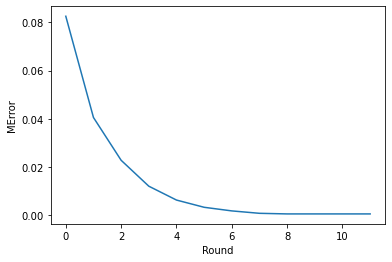

In [49]:
plt.plot(cv_results.iloc[:,0])
plt.ylabel("MLogLoss")
plt.xlabel('Round')

For work here are the hyperparameters we usually try:
max_depth: integers from 8 to 20
min_child_weight: integers from 1 to 100
lambda/reg_lambda: log scaling .001 to 1
alpha/reg_alpha: log scaling .001 to 10
gamma: float between 0 and 4
learning_rate: log scaling .01 to 1
subsample: float between 0.2 and 1
colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1

There are obviously a ton of different possible combinations here, so we can either get Ed to run all the combinations using gridSearch or something, or you can pick the more important ones to test. I would just set learning rate at 0.01 and try changing the max_depth & min_child_weight parameters first

TypeError: 'float' object cannot be interpreted as an integer

EMPO_3 Model Fitting Parameters

parameters | accuracy | training time
--|--|--
n/a|0.004|n/a
lr = 0.01|0.02|n/a
lr=0.01,min_child_weight=1|0.02|780s
lr=0.01,min_child_weight=1,max_depth=8|0.02|771s
lr=0.01,min_child_weight=1,max_depth=10|0.016|833s
lr=0.01,min_child_weight=5,max_depth=8|0.02|695s
lr=0.01,min_child_weight=10,max_depth=8|0.008|549s
lr=0.01,min_child_weight=1,max_depth=8, reg_lambda=0.003|0.016|842s
lr=0.01,min_child_weight=1,max_depth=8, reg_alpha=1|0.016|638s
lr=0.01,min_child_weight=5,max_depth=8, gamma=2|0.02|687s
lr=0.01,min_child_weight=5,max_depth=8, gamma=3|0.02|776s


### Model evaluation

### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

[0]	train-merror:0.04104	validation-merror:0.94000
[1]	train-merror:0.01401	validation-merror:0.95200
[2]	train-merror:0.00801	validation-merror:0.94000
[3]	train-merror:0.00601	validation-merror:0.94400
[4]	train-merror:0.00200	validation-merror:0.94000


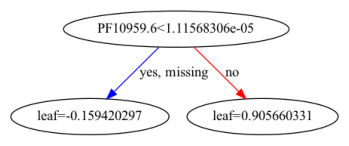

Best Multiclass Log Loss: 0.94 with 1 rounds


In [19]:
params = {
    # parameters to tune
    'eta':0.3,
    'max_depth':7,
    'min_child_weight':1,
    'gamma':0,
    'lambda':1,
    'alpha':0,
    'subsample':1,
    'colsample_bytree':1,
    # other parameters
    'objective':'multi:softmax',
    'num_class':15,
    'eval_metric':['merror']
}
evals_result = {}
num_boost_round = 999
best_model = xgb.train(
    params, 
    d_train,
    num_boost_round = num_boost_round,
    evals=[(d_train, "train"), (d_val, "validation")],
    early_stopping_rounds=5
)
# plot single tree
plot_tree(best_model)
plt.show()
print("Best Multiclass Log Loss: {:.2f} with {} rounds".format(
                 best_model.best_score,
                 best_model.best_iteration+1))

In [29]:
y_pred = best_model.predict(xgb.DMatrix(X_val))
print("Best model accuracy: {}".format(1-best_model.best_score))

index           EMPO_1      EMPO_2                 EMPO_3
1187       Free-living  Non-saline      Soil (non-saline)
264        Free-living  Non-saline  Sediment (non-saline)
967        Free-living  Non-saline     Water (non-saline)
1026       Free-living      Saline         Water (saline)
717        Free-living  Non-saline      Soil (non-saline)
...                ...         ...                    ...
948        Free-living  Non-saline      Soil (non-saline)
741    Host-associated       Plant      Plant rhizosphere
639    Host-associated       Plant      Plant rhizosphere
1126       Free-living      Saline         Water (saline)
773        Free-living  Non-saline      Soil (non-saline)

[250 rows x 3 columns]
Best model accuracy: 0.06000000000000005
Best model accuracy: 0.06


### Save fitted model

In [9]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

# dump(clf, '../model_joblibs/example_multiclass_logreg.joblib')

['../model_joblibs/example_multiclass_logreg.joblib']